# Global and Regional SHAP-DP

This tutorial is an introduction to global and regional SHAP-DP; it demonstrates how to use `Effector` to explain a black box function, utilizing two synthetic datasets—one with uncorrelated features and the other with correlated features.

In [1]:
import numpy as np
import effector

## Simulation example

### Data Generating Distribution

We will generate $N=1000$ examples with $D=3$ features. In the uncorrelated setting, all variables are uniformly distributed, i.e., $x_i \sim \mathcal{U}(-1,1)$. In the correlated setting, we keep the distributional assumptions for $x_1$ and $x_2$ but define $x_3$ such that it is identical to $x_3$ by: $x_3 = x_1$.

In [2]:
def generate_dataset_uncorrelated(N):
    x1 = np.random.uniform(-1, 1, size=N)
    x2 = np.random.uniform(-1, 1, size=N)
    x3 = np.random.uniform(-1, 1, size=N)
    return np.stack((x1, x2, x3), axis=-1)

def generate_dataset_correlated(N):
    x1 = np.random.uniform(-1, 1, size=N)
    x2 = np.random.uniform(-1, 1, size=N)
    x3 = x1
    return np.stack((x1, x2, x3), axis=-1)

# generate the dataset for the uncorrelated and correlated setting
N = 10_000
X_uncor = generate_dataset_uncorrelated(N)
X_cor = generate_dataset_correlated(N)

### Black-box function

We will use the following linear model with a subgroup-specific interaction term:
 $$ y = 3x_1I_{x_3>0} - 3x_1I_{x_3\leq0} + x_3$$ 

The presence of interaction terms ($3x_1I_{x_3>0}$, $3x_1I_{x_3\leq0}$) makes it impossible to define a solid ground truth effect. However, under some mild assumptions, we can agree tha

### Ground truth effect (uncorrelated setting)

In the uncorrelated scenario, the effects are as follows:

- For the feature $x_1$, the global effect will be $3x_1$ half of the time (when $I_{x_3>0}$) and $-3x_1$ the other half (when $3x_1I_{x_3\leq0}$). This results in a zero global effect with high heterogeneity. The regional effect should be divided into two subregions: $x_3>0$ and $x_3 \leq 0$, leading to two regional effects with zero heterogeneity: $3x_1$ and $-3x_1$.

- For feature $x_2$, the global effect is zero, without heterogeneity.

- For feature $x_3$, there is a global effect of $x_3$ without heterogeneity due to the last term. Depending on the feature effect method, the terms $3x_1I_{x_3>0}$ and $-3x_1I_{x_3\leq0}$ may also introduce some effect.

### Ground truth effect (correlated setting)

In the correlated scenario, where $x_3 = x_1$, the effects are as follows:

- For the feature $x_1$, the global effect is $3x_1I_{x_1>0} - 3x_1I_{x_1\leq 0}$ without heterogeneity. This is because when $x_1>0$, $x_3>0$, so only the term $3x_1$ is active. Similarly, when $x_1\leq 0$, $x_3 \leq 0$, making the term $-3x_1$ active.
- For the feature $x_2$, the global effect is zero, without heterogeneity.
- For the feature $x_3$, the global effect is $x_3$.

In [3]:
def model(x):
    f = np.where(x[:,2] > 0, 3*x[:,0] + x[:,2], -3*x[:,0] + x[:,2])
    return f

def model_jac(x):
    dy_dx = np.zeros_like(x)
    
    ind1 = x[:, 2] > 0
    ind2 = x[:, 2] <= 0
    
    dy_dx[ind1, 0] = 3
    dy_dx[ind2, 0] = -3
    dy_dx[:, 2] = 1
    return dy_dx


In [4]:
Y_cor = model(X_cor)
Y_uncor = model(X_uncor)      

## SHAP DP

### Uncorrelated setting

#### Global SHAP DP

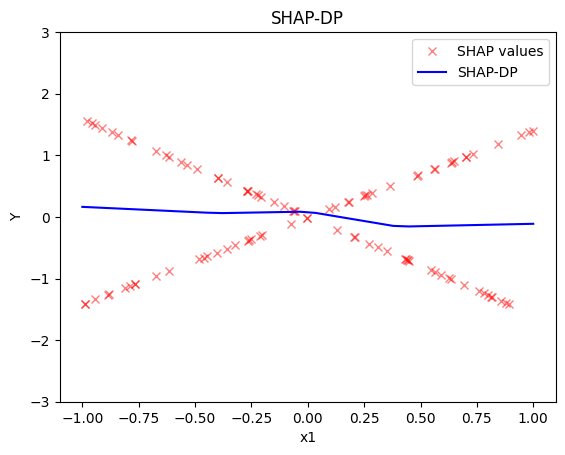

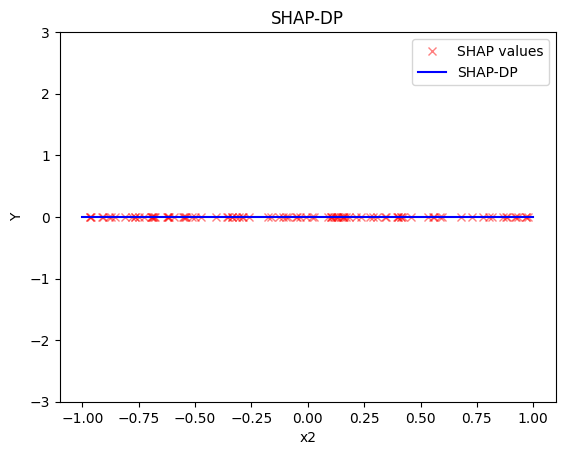

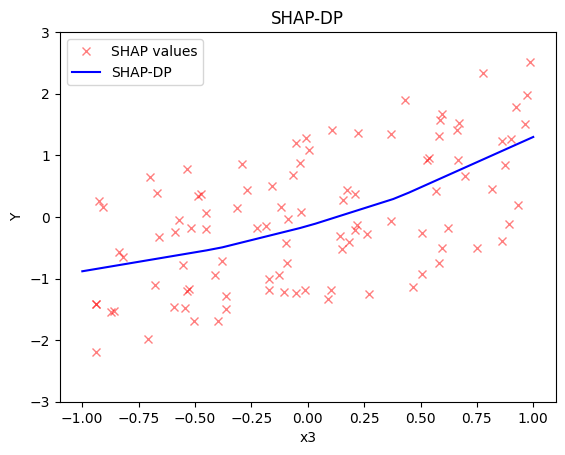

In [10]:
shap = effector.ShapDP(data=X_uncor, model=model, feature_names=['x1','x2','x3'], target_name="Y")
shap.fit(features="all", centering=True, binning_method=effector.axis_partitioning.Fixed(nof_bins=5, min_points_per_bin=0.))
shap.plot(feature=0, centering=True, heterogeneity="shap_values", show_avg_output=False, y_limits=[-3, 3])
shap.plot(feature=1, centering=True, heterogeneity="shap_values", show_avg_output=False, y_limits=[-3, 3])
shap.plot(feature=2, centering=True, heterogeneity="shap_values", show_avg_output=False, y_limits=[-3, 3])

#### Regional SHAP-DP

In [13]:
regional_shap = effector.RegionalShapDP(
    data=X_uncor, 
    model=model, 
    feature_names=['x1', 'x2', 'x3'],
    axis_limits=np.array([[-1, 1], [-1, 1], [-1, 1]]).T) 

regional_shap.fit(
    features="all",
    heter_pcg_drop_thres=0.6,
    nof_candidate_splits_for_numerical=10,
    binning_method=effector.axis_partitioning.Fixed(nof_bins=5, min_points_per_bin=0.)
)

 33%|████████████████████████████████████████████████████████▎                                                                                                                | 1/3 [00:00<00:00,  8.21it/s]

Error: Input array contains only NaN values. This is probably because in all bins there is at most one point, which is not enough to compute the bin variance. Please consider decreasing the number of bins or changing the bin splitting strategy.
Error: Input array contains only NaN values. This is probably because in all bins there is at most one point, which is not enough to compute the bin variance. Please consider decreasing the number of bins or changing the bin splitting strategy.
Error: Input array contains only NaN values. This is probably because in all bins there is at most one point, which is not enough to compute the bin variance. Please consider decreasing the number of bins or changing the bin splitting strategy.
Error: Input array contains only NaN values. This is probably because in all bins there is at most one point, which is not enough to compute the bin variance. Please consider decreasing the number of bins or changing the bin splitting strategy.
Error: Input array c

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 11.42it/s]


In [8]:
regional_shap.summary(0)

Feature 0 - Full partition tree:
Node id: 0, name: x1, heter: 0.79 || nof_instances:   100 || weight: 1.00
        Node id: 1, name: x1 | x3 <= 0.0, heter: 0.00 || nof_instances:    47 || weight: 0.47
        Node id: 2, name: x1 | x3  > 0.0, heter: 0.00 || nof_instances:    53 || weight: 0.53
--------------------------------------------------
Feature 0 - Statistics per tree level:
Level 0, heter: 0.79
        Level 1, heter: 0.00 || heter drop: 0.79 (100.00%)


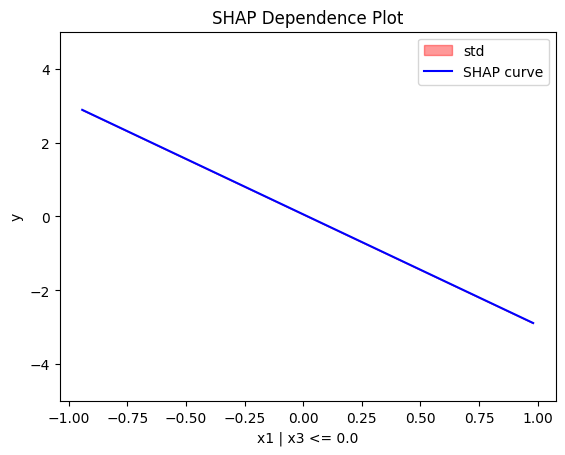

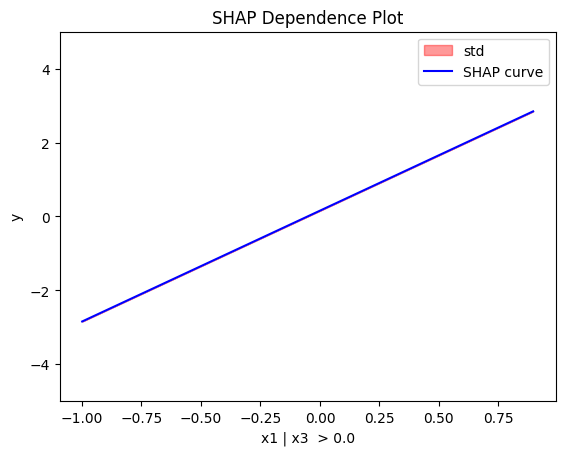

In [9]:
regional_shap.plot(feature=0, node_idx=1, heterogeneity="std", centering=True, y_limits=[-5, 5])
regional_shap.plot(feature=0, node_idx=2, heterogeneity="std", centering=True, y_limits=[-5, 5])

In [10]:
regional_shap.summary(features=1)

Feature 1 - Full partition tree:
Node id: 0, name: x2, heter: 0.00 || nof_instances:   100 || weight: 1.00
--------------------------------------------------
Feature 1 - Statistics per tree level:
Level 0, heter: 0.00


In [11]:
regional_shap.summary(features=2)

Feature 2 - Full partition tree:
Node id: 0, name: x3, heter: 0.68 || nof_instances:   100 || weight: 1.00
--------------------------------------------------
Feature 2 - Statistics per tree level:
Level 0, heter: 0.68


#### Conclusion

Global SHAP-DP:

   * the average effect of $x_1$ is $0$ with some heterogeneity implied by the interaction with $x_1$. The heterogeneity is expressed with two opposite lines; $-3x_1$ when $x_1 \leq 0$ and $3x_1$ when $x_1 >0$
   * the average effect of $x_2$ to be $0$ without heterogeneity
   * the average effect of $x_3$ to be $x_3$ with some heterogeneity due to the interaction with $x_1$. In contrast with other methods, SHAP spread the heterogeneity along the x-axis.
  
Regional SHAP-DP:


### Correlated setting

#### Global SHAP-DP

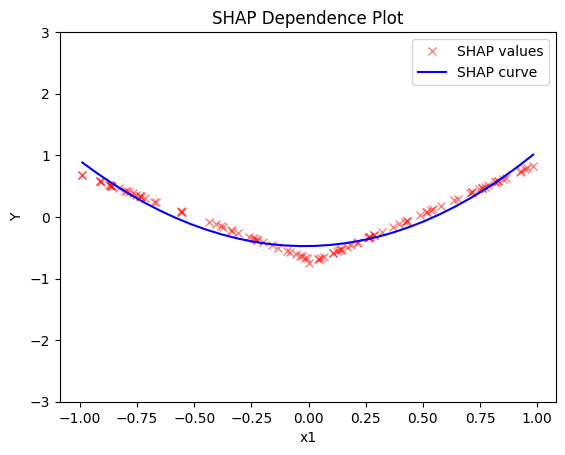

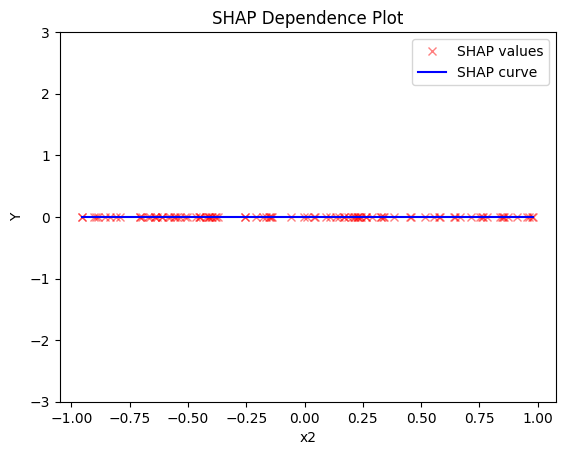

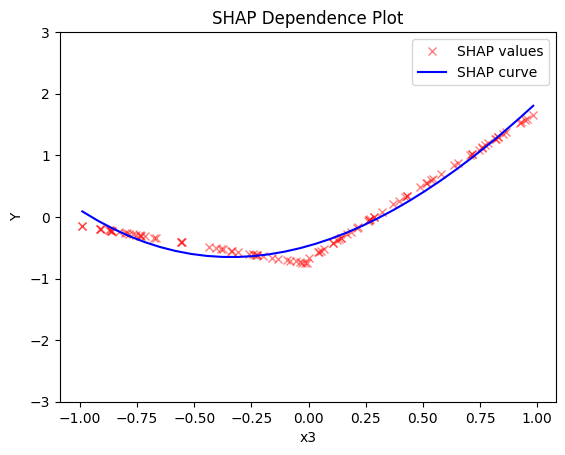

In [13]:
shap = effector.ShapDP(data=X_cor, model=model, feature_names=['x1','x2','x3'], target_name="Y")

shap.plot(feature=0, centering=True, heterogeneity="shap_values", show_avg_output=False, y_limits=[-3, 3])
shap.plot(feature=1, centering=True, heterogeneity="shap_values", show_avg_output=False, y_limits=[-3, 3])
shap.plot(feature=2, centering=True, heterogeneity="shap_values", show_avg_output=False, y_limits=[-3, 3])

#### Regional SHAP

In [15]:
regional_shap = effector.RegionalShapDP(
    data=X_cor, 
    model=model, 
    feature_names=['x1', 'x2', 'x3'],
    axis_limits=np.array([[-1, 1], [-1, 1], [-1, 1]]).T) 

regional_shap.fit(
    features="all",
    heter_pcg_drop_thres=0.6,
    nof_candidate_splits_for_numerical=11
)

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:04<00:00,  1.37s/it]


In [16]:
regional_shap.summary(0)

Feature 0 - Full partition tree:
Node id: 0, name: x1, heter: 0.09 || nof_instances:   100 || weight: 1.00
--------------------------------------------------
Feature 0 - Statistics per tree level:
Level 0, heter: 0.09


In [17]:
regional_shap.summary(1)

Feature 1 - Full partition tree:
Node id: 0, name: x2, heter: 0.00 || nof_instances:   100 || weight: 1.00
--------------------------------------------------
Feature 1 - Statistics per tree level:
Level 0, heter: 0.00


In [18]:
regional_shap.summary(2)

Feature 2 - Full partition tree:
Node id: 0, name: x3, heter: 0.09 || nof_instances:   100 || weight: 1.00
--------------------------------------------------
Feature 2 - Statistics per tree level:
Level 0, heter: 0.09


#### Conclusion

